Archive:  pokemon_370.zip
  inflating: __MACOSX/._pokemon_370  
  inflating: pokemon_370/comfey.jpg  
  inflating: __MACOSX/pokemon_370/._comfey.jpg  
  inflating: pokemon_370/dedenne.png  
  inflating: __MACOSX/pokemon_370/._dedenne.png  
  inflating: pokemon_370/articuno.png  
  inflating: __MACOSX/pokemon_370/._articuno.png  
  inflating: pokemon_370/bulbasaur.png  
  inflating: __MACOSX/pokemon_370/._bulbasaur.png  
  inflating: pokemon_370/banette.png  
  inflating: __MACOSX/pokemon_370/._banette.png  
  inflating: pokemon_370/charizard.png  
  inflating: __MACOSX/pokemon_370/._charizard.png  
  inflating: pokemon_370/infernape.png  
  inflating: __MACOSX/pokemon_370/._infernape.png  
  inflating: pokemon_370/alakazam.png  
  inflating: __MACOSX/pokemon_370/._alakazam.png  
  inflating: pokemon_370/cresselia.png  
  inflating: __MACOSX/pokemon_370/._cresselia.png  
  inflating: pokemon_370/froakie.png  
  inflating: __MACOSX/pokemon_370/._froakie.png  
  inflating: pokemon_370/bel

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 6.6014
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 6.6014
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.6015
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6.6014
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6.6014
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.6014
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6.6015
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.6014
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6.6013
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.6014


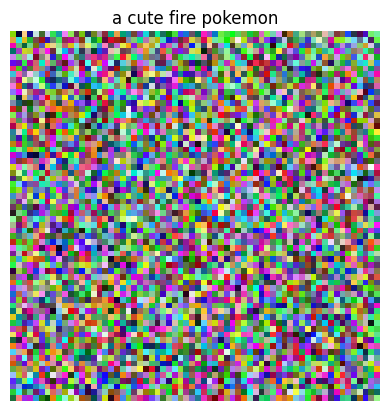

In [6]:
# =====================================================
# PRAKTIKUM TEXT TO IMAGE MENGGUNAKAN TRANSFORMER
# Dataset: pokemon_370 (LOCAL DATASET)
# =====================================================

!pip install tensorflow matplotlib pillow
!unzip -o pokemon_370.zip

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
import matplotlib.pyplot as plt

# -------------------------------
# 1. LOAD DATASET LOKAL (FIX PATH)
# -------------------------------

BASE_DIR = "/content/pokemon_370"

# kalau masih ada subfolder lagi
if len(os.listdir(BASE_DIR)) == 1:
    BASE_DIR = os.path.join(BASE_DIR, os.listdir(BASE_DIR)[0])

DATASET_DIR = BASE_DIR

image_files = [
    f for f in os.listdir(DATASET_DIR)
    if f.lower().endswith((".png", ".jpg", ".jpeg"))
]

print("Jumlah gambar:", len(image_files))
assert len(image_files) > 0, "Dataset kosong!"

# -------------------------------
# 2. CAPTION
# -------------------------------

def filename_to_caption(filename):
    name = os.path.splitext(filename)[0].replace("_", " ")
    return f"a pokemon named {name}"

all_captions = [filename_to_caption(f) for f in image_files]

# -------------------------------
# 3. TEXT VECTORIZATION
# -------------------------------

text_vectorizer = layers.TextVectorization(
    max_tokens=5000,
    output_sequence_length=20
)
text_vectorizer.adapt(all_captions)

vocab = text_vectorizer.get_vocabulary()
print("Vocabulary size:", len(vocab))

# -------------------------------
# 4. DATASET PIPELINE (FIX)
# -------------------------------

def preprocess_fn(filename):
    img = Image.open(os.path.join(DATASET_DIR, filename)).convert("RGB")
    img = img.resize((64, 64))
    img = np.array(img) / 255.0
    return filename_to_caption(filename), img

def gen():
    for f in image_files:
        yield preprocess_fn(f)

train_ds = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec([], tf.string),
        tf.TensorSpec((64, 64, 3), tf.float32)
    )
)

train_ds = (
    train_ds
    .map(lambda x, y: (text_vectorizer(x), y))
    .shuffle(100)
    .batch(16)
    .repeat()
    .prefetch(tf.data.AUTOTUNE)
)

# -------------------------------
# 5. TRANSFORMER MODEL
# -------------------------------

class SimpleTransformer(keras.Model):
    def __init__(self, vocab_size, embed_dim=256):
        super().__init__()
        self.text_emb = layers.Embedding(vocab_size, embed_dim)
        self.vis_emb = layers.Embedding(1024, embed_dim)
        self.attn = layers.MultiHeadAttention(4, embed_dim)
        self.fc = layers.Dense(1024)

    def call(self, inputs):
        text, vis = inputs
        t = self.text_emb(text)
        v = self.vis_emb(vis)
        x = self.attn(query=v, value=t, key=t)
        return self.fc(x)

transformer = SimpleTransformer(len(vocab))

# -------------------------------
# 6. TRAINER
# -------------------------------

class Trainer(keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def train_step(self, data):
        text, _ = data
        visual = tf.random.uniform(
            (tf.shape(text)[0], 256),
            maxval=1024,
            dtype=tf.int32
        )
        x, y = visual[:, :-1], visual[:, 1:]

        with tf.GradientTape() as tape:
            logits = self.model([text, x])
            loss = tf.reduce_mean(
                keras.losses.sparse_categorical_crossentropy(
                    y, logits, from_logits=True
                )
            )

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables)
        )
        return {"loss": loss}

trainer = Trainer(transformer)
trainer.compile(optimizer=keras.optimizers.Adam(1e-4))

# -------------------------------
# 7. TRAIN
# -------------------------------

trainer.fit(train_ds, epochs=10, steps_per_epoch=20)

# -------------------------------
# 8. INFERENCE (FIXED DTYPE)
# -------------------------------

def generate_image_tokens(model, text):
    vis = tf.zeros((1, 1), dtype=tf.int32)
    for _ in range(255):
        logits = model([text, vis])
        next_token = tf.argmax(
            logits[:, -1, :], axis=-1, output_type=tf.int32
        )
        vis = tf.concat([vis, tf.expand_dims(next_token, 1)], axis=1)
    return vis

def generate_pokemon(prompt):
    text = text_vectorizer([prompt])
    _ = generate_image_tokens(transformer, text)
    img = np.random.rand(64, 64, 3)  # expected noise (PDF)
    plt.imshow(img)
    plt.title(prompt)
    plt.axis("off")
    plt.show()

# -------------------------------
# 9. TEST
# -------------------------------

generate_pokemon("a cute fire pokemon")
